# Importing the necessary libraries

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model
import matplotlib.pyplot as plt
import joblib

# Reading and preprocessing of dataset

In [ ]:
num_cols = ['ASHOKLEY','CANBK','LICI','ONGC','SBIN']

In [2]:
dataset = pd.read_csv("D:\\Projects\\Jupyter_Lab\\Stock_market_predictor\\stock_prices_dataset\\Stocks_train.csv")

In [23]:
display(dataset)

,Date,Stock,Close
0,2025-05-30,ASHOKLEY,236.00
1,2025-05-29,ASHOKLEY,240.65
2,2025-05-28,ASHOKLEY,238.50
3,2025-05-27,ASHOKLEY,239.55
4,2025-05-26,ASHOKLEY,239.85
...,...,...,...
3680,2022-06-07,SBIN,463.35
3681,2022-06-06,SBIN,463.55
3682,2022-06-03,SBIN,464.30
3683,2022-06-02,SBIN,469.75


In [98]:
# Pivot with stock column
dataset_train = dataset.pivot(index='Date',columns='Stock',values='Close').reset_index()
display(dataset_train)

Stock,Date,ASHOKLEY,CANBK,LICI,ONGC,SBIN
0,2022-06-01,140.00,208.65,810.55,149.70,468.20
1,2022-06-02,143.45,213.50,805.85,152.50,469.75
2,2022-06-03,139.60,211.10,800.25,151.55,464.30
3,2022-06-06,138.35,210.30,777.40,154.00,463.55
4,2022-06-07,139.60,209.10,752.90,161.85,463.35
...,...,...,...,...,...,...
732,2025-05-26,239.85,107.45,870.00,245.80,794.35
733,2025-05-27,239.55,108.44,871.05,244.55,793.80
734,2025-05-28,238.50,110.88,942.55,242.70,796.45
735,2025-05-29,240.65,110.81,944.40,243.35,797.30


In [99]:
for col in num_cols:
    dataset_train[f'{col}_trend'] = dataset_train[col].diff(periods=-1)
dataset_train = dataset_train.fillna(0)

In [100]:
for col in num_cols:
    dataset_train[f'{col}_trend'] = dataset_train[f'{col}_trend'].shift(-1).rolling(5,min_periods=1).mean().shift(-4)
dataset_train = dataset_train.fillna(0)

In [101]:
dataset_train

Stock,Date,ASHOKLEY,CANBK,LICI,ONGC,SBIN,ASHOKLEY_trend,CANBK_trend,LICI_trend,ONGC_trend,SBIN_trend
0,2022-06-01,140.00,208.65,810.55,149.70,468.20,1.1200,1.210,16.780,-2.620,0.58
1,2022-06-02,143.45,213.50,805.85,152.50,469.75,0.3600,0.610,18.110,-2.610,0.50
2,2022-06-03,139.60,211.10,800.25,151.55,464.30,1.3000,2.620,21.840,-1.100,3.53
3,2022-06-06,138.35,210.30,777.40,154.00,463.55,1.2100,2.390,15.740,1.180,3.11
4,2022-06-07,139.60,209.10,752.90,161.85,463.35,0.7900,4.530,9.510,2.390,3.91
...,...,...,...,...,...,...,...,...,...,...,...
732,2025-05-26,239.85,107.45,870.00,245.80,794.35,0.8875,-1.595,-20.625,1.275,-4.65
733,2025-05-27,239.55,108.44,871.05,244.55,793.80,0.0000,0.000,0.000,0.000,0.00
734,2025-05-28,238.50,110.88,942.55,242.70,796.45,0.0000,0.000,0.000,0.000,0.00
735,2025-05-29,240.65,110.81,944.40,243.35,797.30,0.0000,0.000,0.000,0.000,0.00


In [102]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0,1))
train_data = sc.fit_transform(dataset_train[num_cols+[f'{col}_trend' for col in num_cols]])

In [103]:
train_data

array([[0.07674858, 0.23314899, 0.42471396, ..., 0.88140302, 0.32021348,
        0.5170227 ],
       [0.10283554, 0.24200113, 0.41754386, ..., 0.90449731, 0.32088059,
        0.51435247],
       [0.07372401, 0.23762069, 0.40900076, ..., 0.9692655 , 0.42161441,
        0.61548732],
       ...,
       [0.82155009, 0.05470076, 0.62608696, ..., 0.59003299, 0.49499666,
        0.49766355],
       [0.83780718, 0.054573  , 0.62890923, ..., 0.59003299, 0.49499666,
        0.49766355],
       [0.8026465 , 0.06189199, 0.64286804, ..., 0.59003299, 0.49499666,
        0.49766355]])

In [104]:
# Creating a data structure with 60 time steps and 1 output
X_train = []
y_train = []
for i in range(60,len(train_data)):
    X_train.append(train_data[i-60:i,:])
    y_train.append(train_data[i,:])
X_train, y_train = np.array(X_train), np.array(y_train)

In [105]:
print("Shape of training dataset",X_train.shape)

Shape of training dataset (677, 60, 10)


In [106]:
# Saving min max scaler file
joblib.dump(sc,'D:\\Projects\\Jupyter_Lab\\Stock_market_predictor\\Stock_predictor_BSE_2025\\model_files\\min_max_scaler.joblib')

['D:\\Projects\\Jupyter_Lab\\Stock_market_predictor\\Stock_predictor_BSE_2025\\model_files\\min_max_scaler.joblib']

# Training of GRU model

In [116]:
regressor = Sequential()

regressor.add(GRU(units=500,activation='relu',return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
regressor.add(Dropout(0.05))

"""regressor.add(GRU(units=118,activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(GRU(units=118,activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(GRU(units=118,activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))"""

regressor.add(GRU(units=500,activation='relu'))
regressor.add(Dropout(0.05))

regressor.add(Dense(units=X_train.shape[2]))

regressor.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [117]:
# printing the summary of RNN
print(regressor.summary())

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_16 (GRU)                         │ (None, 60, 500)             │         768,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 60, 500)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_17 (GRU)                         │ (None, 500)                 │       1,503,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │           5,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,276,010 (8.68 MB)

 Trainable params: 2,276,010 (8.68 MB)

 Non-trainable params: 0 (0.00 B)

None


In [118]:
history = regressor.fit(X_train,y_train,epochs=100, batch_size=70,validation_split=0.2)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.2804 - loss: 0.1361 - val_accuracy: 0.0441 - val_loss: 0.0326
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3308 - loss: 0.0282 - val_accuracy: 0.5294 - val_loss: 0.0274
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4251 - loss: 0.0147 - val_accuracy: 0.4265 - val_loss: 0.0165
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.4752 - loss: 0.0118 - val_accuracy: 0.1838 - val_loss: 0.0127
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6107 - loss: 0.0094 - val_accuracy: 0.6250 - val_loss: 0.0107
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5823 - loss: 0.0084 - val_accuracy: 0.7279 - val_loss: 0.0119
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5952 - loss: 0.0082 - val_accuracy: 0.6765 - val_loss: 0.0110
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6055 - loss: 0.0084 - val_accuracy: 0.5809 - val_loss: 0.0102
Epoch 9

# Plotting loss and accuracy curves

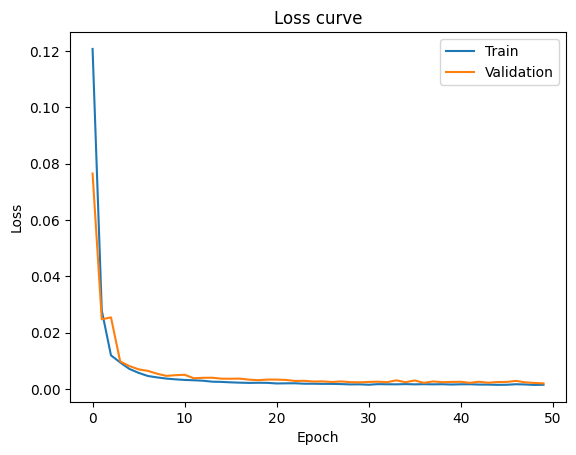

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'])
plt.show()

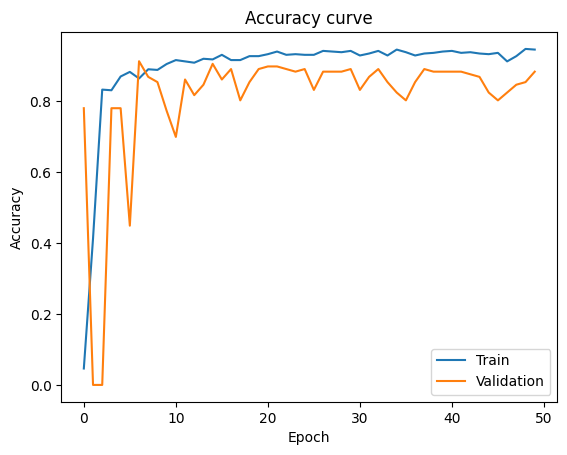

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])
plt.show()

# Saving the model

In [14]:
regressor.save('D:\\Projects\\Jupyter_Lab\\Stock_market_predictor\\Stock_predictor_BSE_2025\\model_files\\stock_predictor.keras')

In [16]:
regressor_load = load_model('D:\\Projects\\Jupyter_Lab\\Stock_market_predictor\\Stock_predictor_BSE_2025\\model_files\\stock_predictor.keras')

In [18]:
regressor_load.predict(X_train)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step


array([[0.14576635, 0.2899355 , 0.18122691, 0.06700765, 0.19596235],
       [0.1497519 , 0.29457095, 0.18321799, 0.06979957, 0.1973482 ],
       [0.15031499, 0.2955167 , 0.18017523, 0.07011744, 0.19393386],
       ...,
       [0.7462009 , 0.0730631 , 0.54962236, 0.60195225, 0.7327398 ],
       [0.7514622 , 0.06994204, 0.57900655, 0.60723805, 0.7396984 ],
       [0.7593029 , 0.06840616, 0.6003049 , 0.6122361 , 0.7437347 ]],
      dtype=float32)